# Spotify - valence
### Theofanis Nitsos | p3352325

Spotify uses a metric called "valence" to measure the happines of each track which value ranges from 0.0 to 1.0.
We will attempt to predict valence by
- understanding which songs' audio features affect valence and which do not, and
- train various machine learning models

The data used come from 2 differnet sources:
- "tracks.csv" (from: https://www.kaggle.com/lehaknarnauli/spotify-datasets) which contains aproximately 586,000 songs and their audio features
- dataset from Zenodo at https://doi.org/10.5281/zenodo.4778562
- validation dataset provided (spotify_ids_holdout)

For predictions, the following methods are used: Beta Regression, Linear Regression, Random Forest, Gradient boosting and XGBoost

## Question 1

We will explore the data, search for correlation and fit OLS regression and GLM to the initial dataset. For this part of the analysis the dataset from Zenodo will be used.

In [1]:
# Importing the libraries i need
import numpy as np 
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn import neighbors
from math import sqrt

/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Importing the dataset
data = pd.read_csv('spotify_hits_dataset_complete.csv', sep='\t')

In [3]:
data.describe()

,popularity,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
count,13880.000000,13880.000000,13880.000000,13880.000000,1.388000e+04,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000
mean,45.196758,4.844813,1.493300,54.974784,2.072193e+05,5.355259,0.529035,3.980043,0.248939,0.687386,0.665731,0.007906,0.182324,-6.298783,0.153850,0.503553,122.374586
std,24.527258,5.063312,0.831394,35.488784,5.011285e+04,3.637565,0.499174,0.298599,0.232277,0.141500,0.161318,0.060343,0.153284,2.395660,0.130988,0.214497,28.124911
min,0.000000,1.000000,1.000000,0.000000,3.040000e+04,0.000000,0.000000,1.000000,0.000003,0.118000,0.005430,0.000000,0.019700,-34.475000,0.023100,0.035400,46.489000
25%,34.000000,1.000000,1.000000,2.000000,1.776675e+05,2.000000,0.000000,4.000000,0.058800,0.598000,0.566000,0.000000,0.096000,-7.474250,0.050100,0.341000,99.955000
50%,51.000000,3.000000,1.000000,79.000000,2.012640e+05,6.000000,1.000000,4.000000,0.177000,0.703000,0.680000,0.000000,0.122000,-6.017000,0.098300,0.502000,121.941000
75%,63.000000,7.000000,2.000000,79.000000,2.286135e+05,8.000000,1.000000,4.000000,0.380000,0.792000,0.784000,0.000014,0.210000,-4.750000,0.240000,0.668000,140.057250
max,100.000000,87.000000,16.000000,79.000000,1.109080e+06,11.000000,1.000000,5.000000,0.994000,0.980000,0.999000,0.960000,0.990000,1.107000,0.966000,0.982000,232.690000


First variables that are not in any way related to valence are dropped. There may be correlation but not causality.

In [4]:
input_data = data.drop(['song_id','song_name', 'artist_id','artist_name',
                        'explicit','song_type','release_date', 'track_number', 
                        'num_artists', 'num_available_markets'], axis=1)

Pairwise plots and scatterplots are used to explore correlation between the variables. Further correlation heatmaps based on the spearman and pearson correlation coefficients are produced. It is worth noting that key, mode and time_signature are categorical variables while the rest are continuous.

In [5]:
# commented out as it takes quite a while to run
# _ = sns.pairplot(input_data, kind="reg", diag_kind="kde", height=1.5, plot_kws={'scatter_kws': {'s': 1.5}})

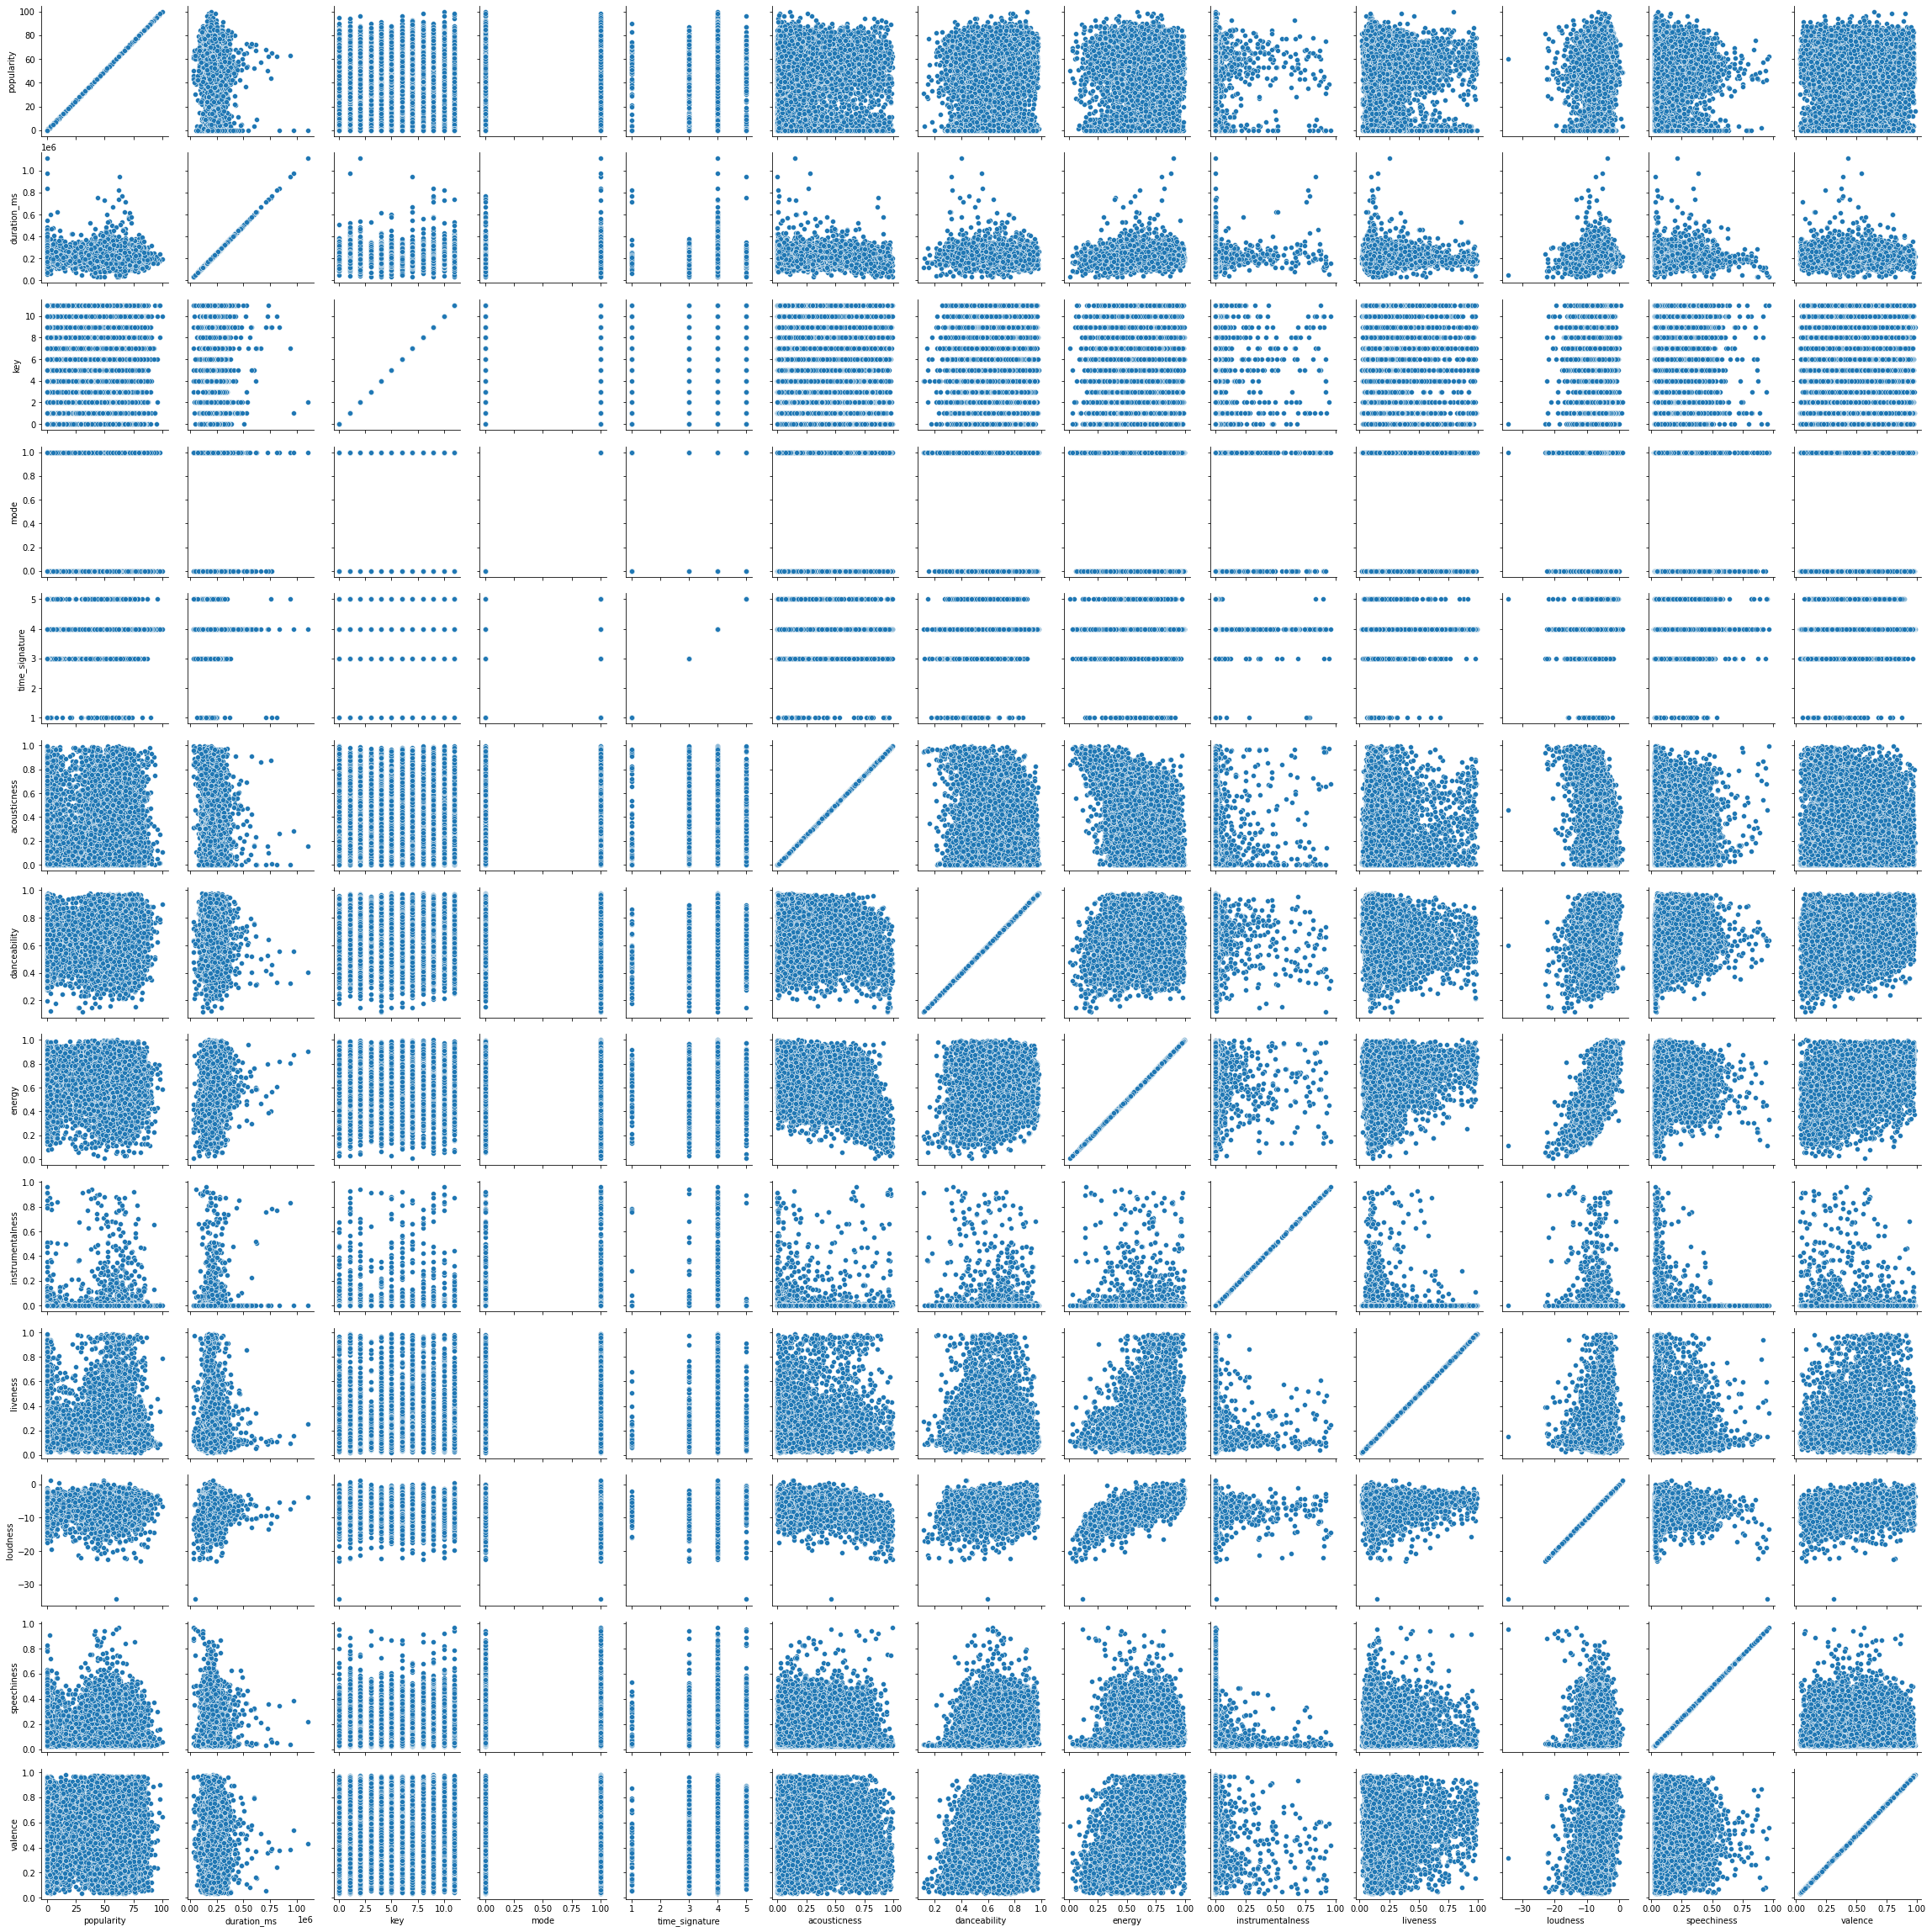

In [6]:
_ = sns.pairplot(input_data.iloc[:, 0:-1], diag_kind=None)

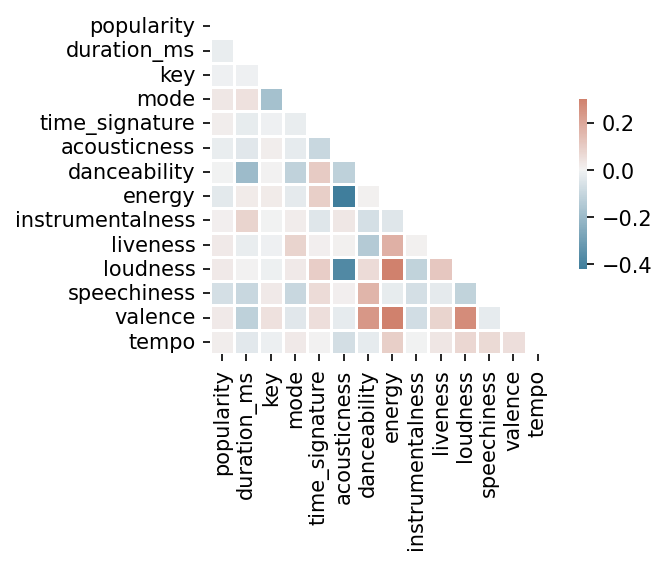

In [7]:
corr = input_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3),dpi = 150)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

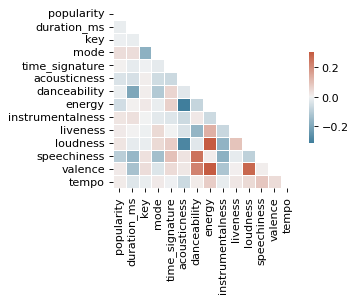

In [8]:
corr_spearman = input_data.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3), dpi=80)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the plots and the heatmaps above it appears that valence is correlated to energy, danceability, loudness and inversely correlated to instrumentalness; which seems reasonable. Further there doesn't seem to be linear dependence between the variables (at least one to one)

For the categorical variables boxplots are used to visualise any correlations.

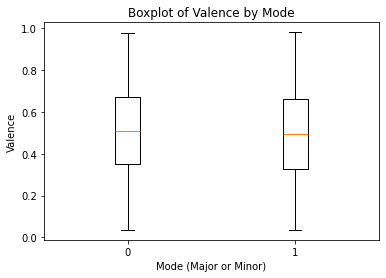

In [9]:
## BoxPlots
# Boxplots for categorical variables
columns_to_plot = ('key', 'mode', 'time_signature')

plt.boxplot([input_data['valence'][input_data['mode'] == category] for category in input_data['mode'].unique()],
            labels=input_data['mode'].unique())
plt.xlabel('Mode (Major or Minor)')
plt.ylabel('Valence')
plt.title('Boxplot of Valence by Mode')
plt.show()

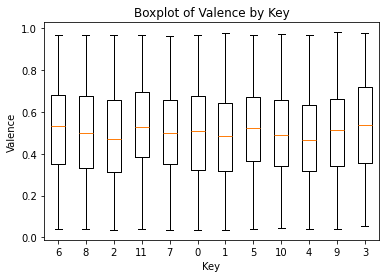

In [10]:
plt.boxplot([input_data['valence'][input_data['key'] == category] for category in input_data['key'].unique()],
            labels=input_data['key'].unique())
plt.xlabel('Key')
plt.ylabel('Valence')
plt.title('Boxplot of Valence by Key')
plt.show()

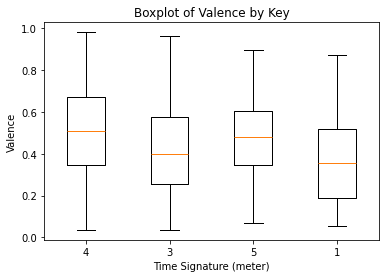

In [11]:
plt.boxplot([input_data['valence'][input_data['time_signature'] == category] for category in input_data['time_signature'].unique()],
            labels=input_data['time_signature'].unique())
plt.xlabel('Time Signature (meter)')
plt.ylabel('Valence')
plt.title('Boxplot of Valence by Key')
plt.show()

Keys and time signature seem to be correlated to valence in contrast to mode

In [12]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        13880 non-null  int64  
 1   duration_ms       13880 non-null  int64  
 2   key               13880 non-null  int64  
 3   mode              13880 non-null  int64  
 4   time_signature    13880 non-null  int64  
 5   acousticness      13880 non-null  float64
 6   danceability      13880 non-null  float64
 7   energy            13880 non-null  float64
 8   instrumentalness  13880 non-null  float64
 9   liveness          13880 non-null  float64
 10  loudness          13880 non-null  float64
 11  speechiness       13880 non-null  float64
 12  valence           13880 non-null  float64
 13  tempo             13880 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 1.5 MB


In [13]:
#input_data['key'] = input_data['key'].astype('category')
#input_data['mode'] = input_data['mode'].astype('category')
#input_data['time_signature'] = input_data['time_signature'].astype('category')
#input_data

In [14]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        13880 non-null  int64  
 1   duration_ms       13880 non-null  int64  
 2   key               13880 non-null  int64  
 3   mode              13880 non-null  int64  
 4   time_signature    13880 non-null  int64  
 5   acousticness      13880 non-null  float64
 6   danceability      13880 non-null  float64
 7   energy            13880 non-null  float64
 8   instrumentalness  13880 non-null  float64
 9   liveness          13880 non-null  float64
 10  loudness          13880 non-null  float64
 11  speechiness       13880 non-null  float64
 12  valence           13880 non-null  float64
 13  tempo             13880 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 1.5 MB


### OLS (Ordinary Least Squares) regression

Valence is a continuous variable taking values between 0.0 and 1.0. As such we can use both an OLS regression model and a generalised linear regression model to predict the valence of a song based on some input variables.

In the first place we will use only the continuous variables in an OLS regression model to evaluate its performance


In [15]:
val_mod = smf.ols(formula="valence ~ energy + popularity + duration_ms + acousticness + danceability + instrumentalness + liveness + loudness + speechiness + tempo", data=input_data)
val_res = val_mod.fit()
val_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     429.9
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:41:05   Log-Likelihood:                 3547.3
No. Observations:               13880   AIC:                            -7073.
Df Residuals:                   13869   BIC:                            -6990.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2100      0.022     -9.721      0.000      -0.252      -0.168
energy               0.6090      0.015     39.955      0.000       0.579       0.639
popularity           0.0003   6.53e-05      4.912      0.000       0.000       0.000
duration_ms      -2.854e-07   3.27e-08     -8.731      0.000   -3.49e-07   -2.21e-07
acousticness         0.1744      0.008     22.635      0.000       0.159       0.189
danceability         0.3983      0.012     33.475      0.000       0.375       0.422
instrumentalness    -0.1617      0.027     -6.038      0.000      -0.214      -0.109
liveness             0.0482      0.011      4.502      0.000       0.027       0.069
loudness            -0.0027      0.001     -2.683      0.007      -0.005      -0.001
speechiness         -0.1146      0.013     -9.106      0.000      -0.139      -0.090
tempo                0.0002   5.71e-05      4.099      0.000       0.000       0.000
==============================================================================
Omnibus:                      138.319   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.440
Skew:                           0.011   Prob(JB):                     6.24e-20
Kurtosis:                       2.610   Cond. No.                     3.64e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the continuous variables the R-squared value is rather low meaning we cannot predict accurately the value of valence and the condition number is large indicating collinearity issues. 

To control for collinearity problems we can calculate VIF

In [16]:
# Check for collinearity problems
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(input_data[['energy', 'acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']])


In [17]:
for i, colname in enumerate(X.columns[1:], 1):
    vif = variance_inflation_factor(X, i)
    print(f'VIF for {colname} = {vif:.2f}')

VIF for energy = 2.37
VIF for acousticness = 1.26
VIF for danceability = 1.08
VIF for instrumentalness = 1.03
VIF for liveness = 1.06
VIF for loudness = 2.29
VIF for speechiness = 1.07
VIF for tempo = 1.02


The VIF values are low thus it does not seem that there are collinearity issues.

To include the effect of categorical variables as well we create dummy variables to incorporate them in the OLS regression model and we calculate the OLS regression model for all the variables.

In [18]:
# categorical variables
lr_df = pd.get_dummies(input_data,columns=['key', 'mode','time_signature'], drop_first=True)
lr_df.replace({True: 1, False: 0}, inplace=True)

In [19]:
#linear regression for all variables
val_mod = smf.ols(formula = "valence ~ " + " + ".join(lr_df.drop(columns=['valence']).columns), data = lr_df)
val_res = val_mod.fit()
val_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     179.0
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:41:06   Log-Likelihood:                 3615.4
No. Observations:               13880   AIC:                            -7179.
Df Residuals:                   13854   BIC:                            -6983.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2045      0.034     -6.072      0.000      -0.270      -0.138
popularity           0.0003    6.5e-05      5.073      0.000       0.000       0.000
duration_ms      -2.756e-07   3.26e-08     -8.444      0.000    -3.4e-07   -2.12e-07
acousticness         0.1718      0.008     22.246      0.000       0.157       0.187
danceability         0.4160      0.012     33.625      0.000       0.392       0.440
energy               0.6104      0.015     39.923      0.000       0.580       0.640
instrumentalness    -0.1626      0.027     -6.092      0.000      -0.215      -0.110
liveness             0.0500      0.011      4.673      0.000       0.029       0.071
loudness            -0.0027      0.001     -2.635      0.008      -0.005      -0.001
speechiness         -0.1148      0.013     -8.953      0.000      -0.140      -0.090
tempo                0.0002    5.7e-05      4.273      0.000       0.000       0.000
key_1               -0.0255      0.007     -3.861      0.000      -0.038      -0.013
key_2               -0.0165      0.008     -2.201      0.028      -0.031      -0.002
key_3                0.0433      0.010      4.145      0.000       0.023       0.064
key_4               -0.0327      0.008     -4.055      0.000      -0.049      -0.017
key_5                0.0169      0.008      2.225      0.026       0.002       0.032
key_6                0.0137      0.007      1.836      0.066      -0.001       0.028
key_7               -0.0017      0.007     -0.235      0.815      -0.016       0.013
key_8                0.0038      0.007      0.519      0.603      -0.011       0.018
key_9                0.0045      0.008      0.593      0.553      -0.010       0.019
key_10              -0.0045      0.008     -0.591      0.554      -0.019       0.010
key_11               0.0188      0.007      2.563      0.010       0.004       0.033
mode_1               0.0073      0.003      2.142      0.032       0.001       0.014
time_signature_3    -0.0093      0.027     -0.338      0.736      -0.063       0.044
time_signature_4    -0.0256      0.026     -0.979      0.328      -0.077       0.026
time_signature_5     0.0134      0.028      0.478      0.633      -0.041       0.068
==============================================================================
Omnibus:                      130.802   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.646
Skew:                           0.012   Prob(JB):                     4.16e-19
Kurtosis:                       2.618   Cond. No.                     7.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+06. 

The R-squared and adjusted R-squared value increased a bit but so did the condition number. 

As a next step we will select the single best model out of the best models with 𝑘=1,2,…,𝑝 independent variables using the adjusted R squared to evaluate the model

In [20]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [21]:
def plot_model_selection(models, best_model, reverse=False, figsize=(6, 4)):
    if reverse:
        models = models[::-1]
    all_rsquared = np.array([ x.rsquared  for x in models ])
    all_rsquared_adj = np.array([ x.rsquared_adj  for x in models ])
    best_indx =len(best_model.model.exog_names) - 1 # take out the intercept
    x = np.arange(1, len(all_rsquared)+1)

    plt.figure(figsize=figsize)
    plt.plot(x, all_rsquared, marker='*', label='$R^2$')
    plt.plot(x, all_rsquared_adj, marker='o', label='Adjusted $R^2$')
    plt.plot(best_indx, all_rsquared_adj[best_indx], marker='x', markersize=14, color='k')
    plt.legend()
    return None

In [22]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [23]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected, model.rsquared_adj)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [24]:
best_model, best_models = forward_stepwise_selection(lr_df, 'valence')
print('Best overall model:', len(best_model.model.exog_names) - 1, best_model.model.exog_names)

Finding the best model for 1 variable
['energy'] 0.1352830206299318
Finding the best model for 2 variables
['energy', 'danceability'] 0.19196788872381143
Finding the best model for 3 variables
['energy', 'danceability', 'acousticness'] 0.22222830634765778
Finding the best model for 4 variables
['energy', 'danceability', 'acousticness', 'duration_ms'] 0.22676051267515995
Finding the best model for 5 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness'] 0.2307857158001556
Finding the best model for 6 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1'] 0.23255187931191146
Finding the best model for 7 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4'] 0.23445594328463537
Finding the best model for 8 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4', 'instrumentalness'] 0.2361737376769063
Finding the best model for 9 variabl

In [25]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     223.6
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:41:11   Log-Likelihood:                 3614.5
No. Observations:               13880   AIC:                            -7187.
Df Residuals:                   13859   BIC:                            -7029.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.2126      0.023     -9.317      0.000      -0.257      -0.168
energy               0.6105      0.015     39.958      0.000       0.581       0.640
danceability         0.4157      0.012     33.625      0.000       0.392       0.440
acousticness         0.1718      0.008     22.258      0.000       0.157       0.187
duration_ms       -2.75e-07   3.26e-08     -8.432      0.000   -3.39e-07   -2.11e-07
speechiness         -0.1147      0.013     -8.958      0.000      -0.140      -0.090
key_1               -0.0259      0.005     -5.231      0.000      -0.036      -0.016
key_4               -0.0330      0.007     -4.898      0.000      -0.046      -0.020
instrumentalness    -0.1623      0.027     -6.085      0.000      -0.215      -0.110
popularity           0.0003    6.5e-05      5.076      0.000       0.000       0.000
liveness             0.0500      0.011      4.667      0.000       0.029       0.071
tempo                0.0002   5.69e-05      4.268      0.000       0.000       0.000
key_3                0.0430      0.009      4.542      0.000       0.024       0.062
key_2               -0.0170      0.006     -2.768      0.006      -0.029      -0.005
time_signature_4    -0.0174      0.009     -1.972      0.049      -0.035      -0.000
loudness            -0.0027      0.001     -2.649      0.008      -0.005      -0.001
key_11               0.0185      0.006      3.164      0.002       0.007       0.030
key_5                0.0166      0.006      2.692      0.007       0.005       0.029
mode_1               0.0076      0.003      2.293      0.022       0.001       0.014
key_6                0.0135      0.006      2.233      0.026       0.002       0.025
time_signature_5     0.0213      0.013      1.587      0.112      -0.005       0.048
==============================================================================
Omnibus:                      130.035   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.274
Skew:                           0.013   Prob(JB):                     5.01e-19
Kurtosis:                       2.619   Cond. No.                     3.67e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

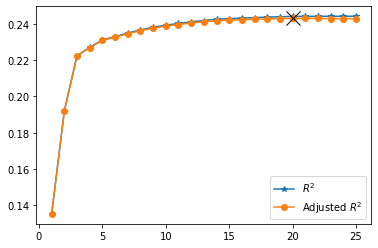

In [26]:
_ = plot_model_selection(best_models, best_model, figsize=(6, 4))

The best overall model is the one with 20 variables (this includes dummy variables as well) but the condition number remains large

As a next step we will normalise the variables to explore the effect it has on our models

In [27]:
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ["duration_ms", "danceability", "energy", "loudness", 
                         "speechiness", "acousticness", "instrumentalness", 
                         "liveness", "tempo"]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
lr_df[columns_to_normalize] = scaler.fit_transform(lr_df[columns_to_normalize])

In [28]:
val_mod = smf.ols(formula = "valence ~ energy + danceability + acousticness + \
duration_ms + speechiness + key_1 + key_4 + \
+ instrumentalness + popularity + liveness + tempo + key_3 + \
key_2 + time_signature_4 + loudness + key_11 + key_5 + mode_1 + \
key_6 + time_signature_5", data = lr_df)
val_res = val_mod.fit()
val_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     223.6
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:41:11   Log-Likelihood:                 3614.5
No. Observations:               13880   AIC:                            -7187.
Df Residuals:                   13859   BIC:                            -7029.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5021      0.009     53.507      0.000       0.484       0.521
energy               0.0985      0.002     39.958      0.000       0.094       0.103
danceability         0.0588      0.002     33.625      0.000       0.055       0.062
acousticness         0.0399      0.002     22.258      0.000       0.036       0.043
duration_ms         -0.0138      0.002     -8.432      0.000      -0.017      -0.011
speechiness         -0.0150      0.002     -8.958      0.000      -0.018      -0.012
key_1               -0.0259      0.005     -5.231      0.000      -0.036      -0.016
key_4               -0.0330      0.007     -4.898      0.000      -0.046      -0.020
instrumentalness    -0.0098      0.002     -6.085      0.000      -0.013      -0.007
popularity           0.0003    6.5e-05      5.076      0.000       0.000       0.000
liveness             0.0077      0.002      4.667      0.000       0.004       0.011
tempo                0.0068      0.002      4.268      0.000       0.004       0.010
key_3                0.0430      0.009      4.542      0.000       0.024       0.062
key_2               -0.0170      0.006     -2.768      0.006      -0.029      -0.005
time_signature_4    -0.0174      0.009     -1.972      0.049      -0.035      -0.000
loudness            -0.0064      0.002     -2.649      0.008      -0.011      -0.002
key_11               0.0185      0.006      3.164      0.002       0.007       0.030
key_5                0.0166      0.006      2.692      0.007       0.005       0.029
mode_1               0.0076      0.003      2.293      0.022       0.001       0.014
key_6                0.0135      0.006      2.233      0.026       0.002       0.025
time_signature_5     0.0213      0.013      1.587      0.112      -0.005       0.048
==============================================================================
Omnibus:                      130.035   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.274
Skew:                           0.013   Prob(JB):                     5.01e-19
Kurtosis:                       2.619   Cond. No.                         534.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After the normalisation of the independent variables and using the best model predicted above the R-squared and adjusted R-squared remains the same but the conidition number decreases significantly.

The variables used for the best model are energy, danceability, acousticness, duration_ms, speechiness, key,
instrumentalness, popularity, liveness, tempo, time_signature, loudness and mode 

We also calculate the MSE and MAE of our OLS regression model

In [29]:
# MSE & MSA calculation
from sklearn.metrics import mean_squared_error

y_actual = lr_df['valence'] 
y_predicted = val_res.predict(lr_df)

mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
print('mean square error is :',mse,' and root of mean square error is :', rmse)

mae = mean_absolute_error(y_actual, y_predicted)
print('mean average error is :',mae)

mean square error is : 0.03478064162091929  and root of mean square error is : 0.18649568794189128
mean average error is : 0.15202899769045017


## GLM

As a next step we will also try using a Generalised Linear Model and more specifically a Beta Regression model

In [30]:
## GLM with continuous variables

fit = smf.glm(formula='valence ~ duration_ms + danceability + energy + loudness + speechiness + acousticness \
            + instrumentalness + liveness + tempo + time_signature', 
              data=input_data, 
              family=sm.families.Binomial(link=sm.families.links.Logit())).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                valence   No. Observations:                13880
Model:                            GLM   Df Residuals:                    13869
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6564.1
Date:                Sun, 07 Jan 2024   Deviance:                       2171.4
Time:                        21:41:12   Pearson chi2:                 2.04e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04348
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.9488      0.333     -8.849      0.000      -3.602      -2.296
duration_ms      -1.246e-06   3.67e-07     -3.396      0.001   -1.97e-06   -5.27e-07
danceability         1.6798      0.132     12.684      0.000       1.420       1.939
energy               2.5163      0.169     14.917      0.000       2.186       2.847
loudness            -0.0089      0.011     -0.803      0.422      -0.031       0.013
speechiness         -0.4853      0.137     -3.535      0.000      -0.754      -0.216
acousticness         0.7214      0.085      8.471      0.000       0.554       0.888
instrumentalness    -0.7448      0.313     -2.380      0.017      -1.358      -0.131
liveness             0.2103      0.118      1.786      0.074      -0.020       0.441
tempo                0.0010      0.001      1.649      0.099      -0.000       0.002
time_signature       0.0174      0.061      0.287      0.774      -0.102       0.136
====================================================================================
"""

In [31]:
# MSE & MSA calculation
y_actual = input_data['valence'] 
y_predicted_glm = fit.predict(input_data)

mse_glm = mean_squared_error(y_actual, y_predicted_glm)
rmse_glm = np.sqrt(mse_glm)
print('mean square error is :',mse_glm,' and root of mean square error is :', rmse_glm)

mae_glm = mean_absolute_error(y_actual, y_predicted_glm)
print('mean average error is :',mae_glm)

mean square error is : 0.03512992606087994  and root of mean square error is : 0.18742978968371046
mean average error is : 0.15279480987175553


In [32]:
## GLM with all variables

fit = smf.glm(formula='valence ~ duration_ms + danceability + energy + loudness + speechiness + acousticness \
            + instrumentalness + liveness + tempo + time_signature + key + mode', 
              data=input_data, 
              family=sm.families.Binomial(link=sm.families.links.Logit())).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                valence   No. Observations:                13880
Model:                            GLM   Df Residuals:                    13867
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6562.3
Date:                Sun, 07 Jan 2024   Deviance:                       2167.7
Time:                        21:41:12   Pearson chi2:                 2.03e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04373
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0186      0.337     -8.957      0.000      -3.679      -2.358
duration_ms      -1.246e-06   3.67e-07     -3.396      0.001   -1.97e-06   -5.27e-07
danceability         1.6877      0.133     12.685      0.000       1.427       1.948
energy               2.5149      0.169     14.848      0.000       2.183       2.847
loudness            -0.0088      0.011     -0.790      0.429      -0.031       0.013
speechiness         -0.4835      0.138     -3.513      0.000      -0.753      -0.214
acousticness         0.7222      0.085      8.468      0.000       0.555       0.889
instrumentalness    -0.7415      0.313     -2.370      0.018      -1.355      -0.128
liveness             0.2070      0.118      1.753      0.080      -0.024       0.438
tempo                0.0010      0.001      1.660      0.097      -0.000       0.002
time_signature       0.0183      0.061      0.302      0.763      -0.101       0.137
key                  0.0092      0.005      1.899      0.058      -0.000       0.019
mode                 0.0234      0.036      0.651      0.515      -0.047       0.094
====================================================================================
"""

In [33]:
# MSE & MSA calculation
y_actual = input_data['valence'] 
y_predicted_glm = fit.predict(input_data)

mse_glm = mean_squared_error(y_actual, y_predicted_glm)
rmse_glm = np.sqrt(mse_glm)
print('mean square error is :',mse_glm,' and root of mean square error is :', rmse_glm)

mae_glm = mean_absolute_error(y_actual, y_predicted_glm)
print('mean average error is :',mae_glm)

mean square error is : 0.03506636098972119  and root of mean square error is : 0.18726014255500606
mean average error is : 0.15264936656205758


In [34]:
fit = smf.glm(formula='valence ~ duration_ms + danceability + energy + loudness + speechiness + acousticness \
            + instrumentalness + liveness + tempo + time_signature + key + mode', 
              data=input_data, 
              family=sm.families.Binomial(link=sm.families.links.Logit())).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                valence   No. Observations:                13880
Model:                            GLM   Df Residuals:                    13867
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6562.3
Date:                Sun, 07 Jan 2024   Deviance:                       2167.7
Time:                        21:41:12   Pearson chi2:                 2.03e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04373
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0186      0.337     -8.957      0.000      -3.679      -2.358
duration_ms      -1.246e-06   3.67e-07     -3.396      0.001   -1.97e-06   -5.27e-07
danceability         1.6877      0.133     12.685      0.000       1.427       1.948
energy               2.5149      0.169     14.848      0.000       2.183       2.847
loudness            -0.0088      0.011     -0.790      0.429      -0.031       0.013
speechiness         -0.4835      0.138     -3.513      0.000      -0.753      -0.214
acousticness         0.7222      0.085      8.468      0.000       0.555       0.889
instrumentalness    -0.7415      0.313     -2.370      0.018      -1.355      -0.128
liveness             0.2070      0.118      1.753      0.080      -0.024       0.438
tempo                0.0010      0.001      1.660      0.097      -0.000       0.002
time_signature       0.0183      0.061      0.302      0.763      -0.101       0.137
key                  0.0092      0.005      1.899      0.058      -0.000       0.019
mode                 0.0234      0.036      0.651      0.515      -0.047       0.094
====================================================================================
"""

In [35]:
y_actual = input_data['valence']
y_predicted = fit.predict(input_data)

mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
print('mean square error is :',mse,' and root of mean square error is :', rmse)

mae = mean_absolute_error(y_actual, y_predicted)
print('mean average error is :',mae)

mean square error is : 0.03506636098972119  and root of mean square error is : 0.18726014255500606
mean average error is : 0.15264936656205758


The MAE is very similar among the OLS regression and the GLM Beta regression

## Question 2 - MACHINE LEARNING

As a next step we will train 4 machine learning models on the same dataset splitting the dataset in train and test, using a 80%-20% split and evaluate the MAE between the different methods. The methods used are:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost

In [36]:
feats = ["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness",
            "instrumentalness", "liveness", "tempo", "time_signature"] 

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

X = input_data[feats]
y = input_data["valence"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
linear_reg_pred = linear_reg_model.predict(X_test)
linear_reg_mse = mean_squared_error(y_test, linear_reg_pred)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_pred)

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

# 3. Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

# Print Mean Squared Error for each model
print("Linear Regression MSE:", linear_reg_mse)
print("Random Forest MSE:", rf_mse)
print("Gradient Boosting MSE:", gb_mse)

# Print Mean Absolute Error for each model
print("Linear Regression MAE:", linear_reg_mae)
print("Random Forest MAE:", rf_mae)
print("Gradient Boosting MAE:", gb_mae)

Linear Regression MSE: 0.03380039429266207
Random Forest MSE: 0.027286677746231988
Gradient Boosting MSE: 0.03123028665618058
Linear Regression MAE: 0.15014970105282818
Random Forest MAE: 0.12974881628242077
Gradient Boosting MAE: 0.14392808325433404


In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgboost_model = XGBRegressor() 

parameters = {
              'eval_metric':['mae'],
              'gamma':  [0, 0.2 ], 
              'max_depth': [6, 7, 8],
              }

xgb_grid = GridSearchCV(xgboost_model,
                        parameters,
                        cv = 2,
                        verbose=False,
                        n_jobs=-1   
                        )

xgb_grid.fit(X_train, y_train)


print("Best Parameters: ", xgb_grid.best_params_)
xgb_pred = xgb_grid.predict(X_test)
print("Mean Absolute Error: " + str(round(mean_absolute_error(xgb_pred, y_test), 3)))

/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/fanis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/fanis/opt/a

Best Parameters:  {'eval_metric': 'mae', 'gamma': 0.2, 'max_depth': 8}
Mean Absolute Error: 0.143


The Random Forest appears to have the best performance based on MAE, followed by the Gradient Boosting and XGBoost and last is the Linear Regression model. This is to be expected as the Linear Regression model is the simplest of these models but it is worth noting that both the MAE and MSE are improved but not dramatically. 

### Random Forest hyperparameter tuning
As the next step we will try to tune the hyperparameters of the Random Forest Regresson and the Gradient Boosting Regressor to improve our predictions, explore which features influence the valence metric and calculate MAE and MSE again.

In [39]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters to tune
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform randomized search
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search_rf.fit(X_train, y_train)

# Best hyperparameters
best_rf_params = random_search_rf.best_params_

# Use the best model
best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

best_rf_pred = best_rf_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
best_rf_mae = mean_absolute_error(y_test, best_rf_pred)

print("BEST Random Forest MSE:", best_rf_mse)
print("BEST Random Forest MAE:", best_rf_mae)


BEST Random Forest MSE: 0.02690781511014778
BEST Random Forest MAE: 0.1294313722982709


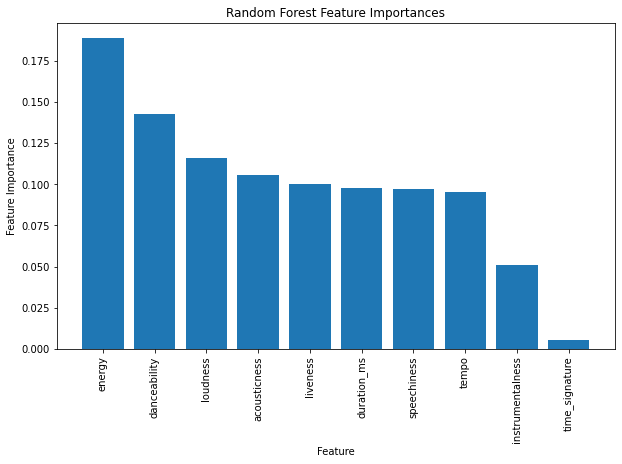

In [40]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort indices in descending order based on feature importances
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

After the hyperparameter tuning both MSE and MAE improve but not considerably.

Further we notice that energy remains the most important variable followed by danceability and loudness (the variables that we identified having a correlation with valence). Is is worth noting that the rest of the continuous variables appear to be significant

### Gradient Boosting hyperparameter tuning

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a Gradient Boosting model with early stopping
best_gb_model = GradientBoostingRegressor(
    n_estimators=1000,  # Set a large number of estimators
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    validation_fraction=0.1,  # Fraction of training data to set aside as validation set
    n_iter_no_change=10,  # Number of iterations with no improvement on the validation set to trigger early stopping
    tol=0.001,  # Tolerance to declare convergence
)

# Fit the model on the training set with early stopping
best_gb_model.fit(X_train, y_train)

# Evaluate on the validation set
best_gb_pred_test = best_gb_model.predict(X_test)
best_gb_mse_test = mean_squared_error(y_test, best_gb_pred_test)
best_gb_mae_test = mean_absolute_error(y_test, best_gb_pred_test)

print("Best Gradient Boosting Validation MSE:", best_gb_mse_test)
print("Best Gradient Boosting Validation MAE:", best_gb_mae_test)


Best Gradient Boosting Validation MSE: 0.03144704775590218
Best Gradient Boosting Validation MAE: 0.1442063003632244


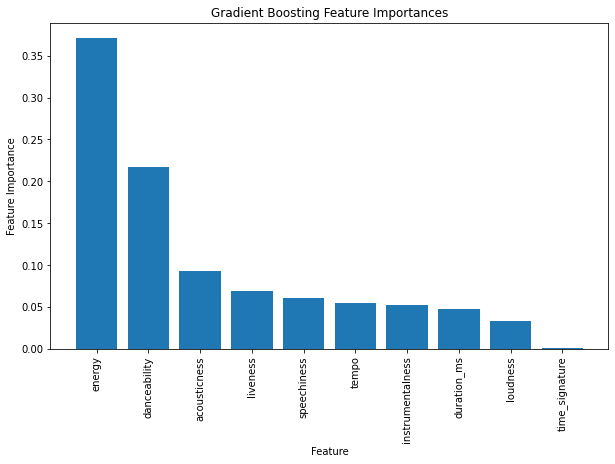

In [42]:
# Get feature importances
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort indices in descending order based on feature importances
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Gradient Boosting Feature Importances")
plt.show()


The Gradient Boosting model hyperparameter tuning did not improve the MAE and MSE. That is likely due to the fact that we used early stopping as grid search was computationally expensive and took a long time to calculate. Further in this model energy and danceability is far more important than the other variables, while loudness is significantly less important.

### Remarks

- Feature importance seems more balanced in the Random Forest regressor than Gradient Boosting
- Normalisation of the variables did not yield any improvements of the MAE or the MSE 
- One hot encoding, in order to use the categorical variables did not lead to improvements of the MAE or the MSE
- Using a larger training dataset (approx. 600,000 songs) led to marginally smaller in-sample MAE

## GET DATA FROM SPOTIFY

we will use the provided holdout txt to download the required song ids and store them in the holdout_list.csv. Then the above calculated models will be used to predict the valence and compare them to the actual valence calculating MAE.

In [43]:
import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [52]:
# Please provide your credentials! 
cid = '##########'
secret = '########'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [45]:
dat = pd.read_csv("spotify_ids_holdout.txt")
dat.columns = ["song_id"]
dat

,song_id
0,56y1jOTK0XSvJzVv9vHQBK
1,3rUGC1vUpkDG9CZFHMur1t
2,01qFKNWq73UfEslI0GvumE
3,2YSzYUF3jWqb9YP9VXmpjE
4,7aqfrAY2p9BUSiupwk3svU
...,...
1010,3fDTzkvrOo5xQIO480Qmsb
1011,4Ls53fBNVfaXTROBi6X8Hw
1012,5PLqXnvHH7Gh6CcfiUEr7e
1013,0hDE81j4N2DPLbEY4tiCDs


In [53]:
features = {}
all_track_ids = list(dat['song_id'].unique())

In [54]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100


In [48]:
holdout_df = pd.DataFrame.from_dict(features, orient='index').rename_axis('song_id').reset_index()

In [49]:
holdout_df.to_csv('holdout_list.csv', index=False)

In [50]:
holdout_df_2 = pd.read_csv("holdout_list.csv")
holdout_df_2

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,56y1jOTK0XSvJzVv9vHQBK,0.864,0.556,2,-7.683,0,0.1940,0.25500,0.000004,0.1120,0.7260,99.974,audio_features,56y1jOTK0XSvJzVv9vHQBK,spotify:track:56y1jOTK0XSvJzVv9vHQBK,https://api.spotify.com/v1/tracks/56y1jOTK0XSv...,https://api.spotify.com/v1/audio-analysis/56y1...,230480,4
1,3rUGC1vUpkDG9CZFHMur1t,0.750,0.733,6,-3.180,0,0.0319,0.25600,0.000000,0.1140,0.8440,111.018,audio_features,3rUGC1vUpkDG9CZFHMur1t,spotify:track:3rUGC1vUpkDG9CZFHMur1t,https://api.spotify.com/v1/tracks/3rUGC1vUpkDG...,https://api.spotify.com/v1/audio-analysis/3rUG...,131872,1
2,01qFKNWq73UfEslI0GvumE,0.853,0.824,1,-3.287,1,0.1030,0.03220,0.000000,0.0859,0.8880,108.044,audio_features,01qFKNWq73UfEslI0GvumE,spotify:track:01qFKNWq73UfEslI0GvumE,https://api.spotify.com/v1/tracks/01qFKNWq73Uf...,https://api.spotify.com/v1/audio-analysis/01qF...,201812,4
3,2YSzYUF3jWqb9YP9VXmpjE,0.663,0.670,8,-8.399,1,0.2710,0.04640,0.000089,0.2050,0.1380,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4
4,7aqfrAY2p9BUSiupwk3svU,0.470,0.640,2,-7.779,1,0.3200,0.02770,0.000000,0.3820,0.2480,163.920,audio_features,7aqfrAY2p9BUSiupwk3svU,spotify:track:7aqfrAY2p9BUSiupwk3svU,https://api.spotify.com/v1/tracks/7aqfrAY2p9BU...,https://api.spotify.com/v1/audio-analysis/7aqf...,247444,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,3fDTzkvrOo5xQIO480Qmsb,0.538,0.783,11,-2.565,0,0.2220,0.01130,0.000000,0.2810,0.5530,75.388,audio_features,3fDTzkvrOo5xQIO480Qmsb,spotify:track:3fDTzkvrOo5xQIO480Qmsb,https://api.spotify.com/v1/tracks/3fDTzkvrOo5x...,https://api.spotify.com/v1/audio-analysis/3fDT...,259080,4
1011,4Ls53fBNVfaXTROBi6X8Hw,0.485,0.545,11,-7.924,1,0.0336,0.06510,0.005470,0.0642,0.0385,150.185,audio_features,4Ls53fBNVfaXTROBi6X8Hw,spotify:track:4Ls53fBNVfaXTROBi6X8Hw,https://api.spotify.com/v1/tracks/4Ls53fBNVfaX...,https://api.spotify.com/v1/audio-analysis/4Ls5...,123891,4
1012,5PLqXnvHH7Gh6CcfiUEr7e,0.600,0.600,2,-7.715,0,0.1150,0.00388,0.000000,0.1220,0.5950,90.435,audio_features,5PLqXnvHH7Gh6CcfiUEr7e,spotify:track:5PLqXnvHH7Gh6CcfiUEr7e,https://api.spotify.com/v1/tracks/5PLqXnvHH7Gh...,https://api.spotify.com/v1/audio-analysis/5PLq...,194920,3
1013,0hDE81j4N2DPLbEY4tiCDs,0.750,0.830,0,-3.544,1,0.0683,0.11500,0.000000,0.7650,0.6880,104.937,audio_features,0hDE81j4N2DPLbEY4tiCDs,spotify:track:0hDE81j4N2DPLbEY4tiCDs,https://api.spotify.com/v1/tracks/0hDE81j4N2DP...,https://api.spotify.com/v1/audio-analysis/0hDE...,182857,4


In [51]:
X_holdout = holdout_df_2[feats]
y_holdout = holdout_df_2["valence"]

# 1. Linear Regression
linear_reg_pred = linear_reg_model.predict(X_holdout)
linear_reg_mse = mean_squared_error(y_holdout, linear_reg_pred)
linear_reg_mae = mean_absolute_error(y_holdout, linear_reg_pred)

# 2. Random Forest Regressor
rf_pred = best_rf_model.predict(X_holdout)
rf_mse = mean_squared_error(y_holdout, rf_pred)
rf_mae = mean_absolute_error(y_holdout, rf_pred)

# 3. Gradient Boosting Regressor
gb_pred = gb_model.predict(X_holdout)
gb_mse = mean_squared_error(y_holdout, gb_pred)
gb_mae = mean_absolute_error(y_holdout, gb_pred)

# 4. XGBoost
xgb_pred = xgb_grid.predict(X_holdout)
xgb_mse = mean_squared_error(y_holdout, xgb_pred)
xgb_mae = mean_absolute_error(y_holdout, xgb_pred)

# Print Mean Squared Error for each model
print("Linear Regression MSE:", linear_reg_mse)
print("Random Forest MSE:", rf_mse)
print("Gradient Boosting MSE:", gb_mse)
print("XGBoost MSE:", xgb_mse)

# Print Mean Absolute Error for each model
print("Linear Regression MAE:", linear_reg_mae)
print("Random Forest MAE:", rf_mae)
print("Gradient Boosting MAE:", gb_mae)
print("XGBoost MAE:", xgb_mae)

Linear Regression MSE: 0.04095251467941282
Random Forest MSE: 0.033578093206297045
Gradient Boosting MSE: 0.03622136338621553
XGBoost MSE: 0.035476591862255165
Linear Regression MAE: 0.16576310958441856
Random Forest MAE: 0.1455610660098522
Gradient Boosting MAE: 0.1545882879741103
XGBoost MAE: 0.15286396488793377


## Conclusion
The Random Forest provides the best MAE on the new validation dataset provided. 
The MAE is calculated at 0.1455

Also it is worth noting that when training the models on bigger dataset (code not included) the improvements were marginal, if any.

In order to improve the predictions of our model it would be advised to extract more data from each song using the Track's Audio Analysis through the spotify API. By utilising sp.audio_analysis(track_id) we can asses more data for each song. Because of having to retrieve each and every song individually and parse through a lot of information it is time-consuming to create a suitable dataset.